In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import jacobian, hessian
import torchvision as tv
from nn_tools.model_builder import Network
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm
%matplotlib inline

MODEL_SEED = 2824180  # chosen by keyboard-mashing
DATA_SEED = MODEL_SEED + 10

data = tv.datasets.CIFAR10('data/cifar10',
                           train=True,
                           transform=tv.transforms.ToTensor())
loader = torch.utils.data.DataLoader(data,
                                     batch_size=128,
                                     shuffle=True,
                                     generator=torch.Generator().manual_seed(DATA_SEED),
                                     pin_memory=True,
                                     num_workers=16)

# Get a single example batch for testing
im, la = next(iter(loader))

## Make a convnet

In [2]:
def get_model_def():
    return {
        'input': None,
        'stack1': {
            'bn': nn.BatchNorm2d(num_features=3),
            'conv': nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack2': {
            'bn': nn.BatchNorm2d(num_features=32),
            'conv': nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack3': {
            'bn': nn.BatchNorm2d(num_features=64),
            'conv': nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(2)
        },
        'stack4': {
            'bn': nn.BatchNorm2d(num_features=128),
            'conv': nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            'relu': nn.ReLU(),
            'pool': nn.MaxPool2d(4)
        },
        'proj': nn.Sequential(nn.Flatten(), nn.Linear(256, 10))
    }

In [3]:
torch.manual_seed(MODEL_SEED)
mdl = Network(get_model_def())

## Two functions for getting size-`(channels, channels, h*w)` hessian, summed over batches

In [4]:
def sum_hessian_naive(loss, hidden):
    """Given scalar tensor 'loss' and (b,c,h,w) batch of feature planes, computes (c,c)-size
     sum of hessians, summed over both the batch dimension and space.

    We make use of the fact that grad^2(f) = grad(grad(f)) and that sum of grads = grad of sum. So, sum(grad^2(f)) is
    computed as grad(sum(grad(f))), with sums taken over the batch dimension.
    """
    b, c, h, w = hidden.size()
    hessian = hidden.new_zeros(c, c)
    grad = torch.autograd.grad(loss, hidden, retain_graph=True, create_graph=True)[0]
    sum_grad = torch.sum(grad, dim=0)
    progbar = tqdm(desc='naive hessian', total=c*h*w)
    for i in range(c):
        # NOTE: this is inefficient because it computes the hessian w.r.t. all x,y,x',y' pairs of location, only for us
        # to subselect later where x==x' and y==y'. Alas, torch doesn't let us take the grad w.r.t. a subset of
        # features, since slice operations break dependency graph.
        for y, x in itertools.product(range(h), range(w)):
            progbar.update(1)
            hess_ixy = torch.autograd.grad(sum_grad[i, y, x], hidden, retain_graph=True)[0]
            hessian[i, :] += hess_ixy[:, :, y, x].sum(dim=0)
    return hessian


def sum_hessian_functional(model, loss_fn, hidden, layer_name):
    """The key idea here is to define a local function that 'injects' some new activity into a layer, then
    runs the model forward from there and re-calculates the loss. We can then make use of hessian
    to compute the channels x channels hessian per batch & location, without additional memory overhead computing
    the hessian w.r.t. pairs of units we don't care about.
    """
    b, c, h, w = hidden.size()
    hidden = hidden.detach()
    hessian = hidden.new_zeros(c, c)
    for y, x in tqdm(itertools.product(range(h), range(w)), total=w*h, desc='functional hessian'):
        tmp = hidden.clone()
        
        def inject_and_calculate_loss(h_slice):
            tmp[:, :, y, x] = h_slice
            new_out = model({layer_name: tmp}, warn_if_missing=False)
            return loss_fn(new_out)
        
        def jacobian_at_yx(h_slice):
            # Jacobian of loss w.r.t (batch, channels) slice
            batch_jacobian = jacobian(inject_and_calculate_loss, h_slice, create_graph=True)
            # Sum over batches --> output is size (channels,)
            return batch_jacobian.sum(dim=0)
        
        # Hessian is grad(grad(loss)). Implement here as jacobian(jacobian(...)), summed over batches.
        # Note: the_slice cannot just be tmp[:,:,y,x], since this is a 'slice' type, and for whatever
        # reason it results in all-zeros in the hessian. My theory is that you can't re-use a slice
        # view twice, and there is a kind of implicit retain_graph=True when doing create_graph=True.
        # The upshot is that .clone() on the view gives us a tensor that behaves more cleanly as a
        # leaf in the computation graph.
        the_slice = tmp[:,:,y,x].clone()
        batch_hessian_at_yx = jacobian(jacobian_at_yx, the_slice)
        # In virtue of being a jacobian of a jacobian, the size of batch_hessian_at_yx is
        # (channels, batch, channels). Sum over the batch dimension:
        hessian += batch_hessian_at_yx.sum(dim=1)
    return hessian


def sum_hessian_functional2(model, loss_fn, hidden, layer_name):
    """Like sum_hessian_functional but using torch's hessian() instead of our own jacobian(jacobian(...)).
    
    This is SLOW. We include an optimization in sum_hessian_functional by summing over batches in between, i.e.
    we do jacobian(sum(jacobian(...), dim=0)). This function instead loops over batches, and can take hours
    to run for a single batch/layer.
    """
    b, c, h, w = hidden.size()
    hidden = hidden.detach()
    hess = hidden.new_zeros(c, c)
    for i, y, x in tqdm(itertools.product(range(b), range(h), range(w)), total=b*w*h, desc='functional hessian v2'):
        tmp = hidden.clone()
        
        def inject_and_calculate_loss(h_slice):
            tmp[i, :, y, x] = h_slice
            new_out = model({layer_name: tmp}, warn_if_missing=False)
            return loss_fn(new_out)
        
        the_slice = tmp[i,:,y,x].clone()
        hess += hessian(inject_and_calculate_loss, the_slice)
    return hess

In [5]:
device = 'cuda:0'
mdl.to(device)
im, la = next(iter(loader))
im, la = im.to(device), la.to(device)
layer_name = 'stack1/relu'

In [6]:
out = mdl({'input': im})
loss = F.cross_entropy(out['proj'], la)
hidden = out[layer_name]
hessian1 = sum_hessian_naive(loss, hidden)

naive hessian:   0%|          | 0/32768 [00:00<?, ?it/s]

In [7]:
out = mdl({'input': im})
hidden = out[layer_name]
hessian2 = sum_hessian_functional(mdl, lambda o: F.cross_entropy(o['proj'], la), hidden, layer_name)

functional hessian:   0%|          | 0/1024 [00:00<?, ?it/s]

Note: `sum_hessian_functional2` is too slow (like >2 hours to compute `hessian3`). Skipping it...

In [8]:
# out = mdl({'input': im})
# hidden = out[layer_name]
# hessian3 = sum_hessian_functional2(mdl, lambda o: F.cross_entropy(o['proj'], la), hidden, layer_name)

### Scatter plot: did the two hessian methods agree?

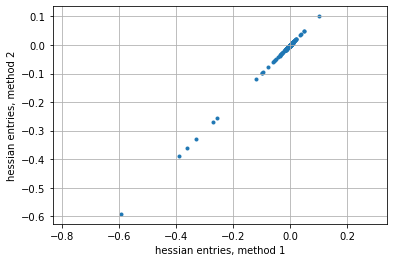

In [9]:
plt.figure()
plt.scatter(hessian1.flatten().cpu(), hessian2.flatten().cpu(), marker='.')
plt.axis('equal')
plt.grid('on')
plt.xlabel('hessian entries, method 1')
plt.ylabel('hessian entries, method 2')
plt.show()